# **Tối ưu tổ hợp trên đồ thị**

## **Bài toán quy hoạch tuyến tính nguyên**


Bài toán quy hoạch nguyên (Integer Programming - IP) được mô hình hóa toán học như sau:
\begin{gather*}
    \max f(x) = c^T x \\
    v.d.k \quad x = (x_1, x_2, \dots, x_n) \in D \\
    g_i(x) \leq 0, \quad i = 1, 2, \dots, m^* \\
    h_i(x) = 0, \quad i = m^* + 1, \dots, m \\
    x_j \in N, \quad j = 1, 2, \dots, n^*
\end{gather*}
Nếu $n^* = n$ thì ta có bài toán nguyên toàn phần (Pure Integer Programming), còn nếu $n^* < n$ thì ràng buộc chỉ còn một số nguyên nhất định, ta gọi bài toán này là quy hoạch nguyên một phần (Mixed Integer Programming). Ở đây ta chỉ xét hàm mục tiêu $f(x)$ và điều kiện $g_i(x), h_i(x)$ là các hàm số tuyến tính. Để bài toán quy hoạch tuyến tính nguyên có nghiệm thì bài toán quy hoạch tuyến tính nới lỏng (bỏ đi điều kiện nguyên) cũng phải có nghiệm (bounded). Tức nghiệm thuộc trong vùng không gian giới hạn bởi các siêu mặt phẳng (hyperlane) cắt nhau trong không gian tạo thành khối đa diện.

Giải bài toán quy hoạch tuyến tính nguyên với hai solver là **phương pháp đơn hình** và **phương pháp điểm trong** cho bài toán quy hoạch tuyến tính nới lỏng.

In [2]:
import numpy as np

class DotDict:
    def __init__(self, dictionary):
        self.__dict__ = dictionary

### **Phương pháp đơn hình - Simplex method**

In [56]:
class Simplex:
    def __init__(self, A, b, c, real_num_var):
        self.A = A
        self.b = b
        self.c = c
        self.n = len(c)
        self.m = len(b)
        self.real_num_var = real_num_var
        
        tableau = np.zeros((self.m + 1, self.n + 1))
        tableau[:-1, :-1] = A
        tableau[:-1, -1] = b
        tableau[-1, :self.n] = c
        self.tableau = tableau
    
    def run(self):
        while True:
            if np.all(self.tableau[-1, :-1] >= 0):
                break

            # Tìm ra k là hướng đi làm tăng hàm mục tiêu nhanh nhất
            # Ở đây ta argmin là vì đã đổi thành dấu âm
            k = np.argmin(self.tableau[-1, :-1])
            
            # Nếu mà giá trị b âm thì dừng vì ta đang chỉ xét b dương cho nghiệm chấp nhận được
            if np.all(self.tableau[:-1, k] <= 0):
                return DotDict({'x': None, 'fun': None, 'success': False})

            # Tìm ra l là giới hạn mà ta có thể đi theo cạnh để tránh đi vượt giới hạn
            # l sẽ lấy giá trị nhỏ nhất của giá trị b chia cho cột k
            ratios = self.tableau[:-1, -1] / (self.tableau[:-1, k] + 1e-9)
            l = np.where(ratios == np.min(ratios[ratios > 0]))[0][0]

            # Thực hiện phép xoay bằng phép biến đổi dòng trên ma trận
            self.tableau[l] /= self.tableau[l, k]

            for i in range(self.m + 1):
                if i != l:
                    self.tableau[i] -= self.tableau[i, k] * self.tableau[l]

        # Nếu như có nghiệm trả ra âm thì ta kết luận bài toán
        # quy hoạch tuyến tính nới lỏng không giải được
        sol = self.tableau[:-1, -1]
        negative = np.any(sol < 0)
        
        if negative:
            return DotDict({'x': None, 'fun': None, 'success': False})
        
        # Trích xuất ra các biến gốc và bỏ đi các biến phụ (slack) khi trả về
        x = np.zeros(self.real_num_var)
        for i in range(self.real_num_var):
        
            row = np.where(self.tableau[:-1, i] == 1)[0]
            if len(row) == 1:
                x[i] = self.tableau[row[0], -1]

        return DotDict({'x': x, 'fun': (np.array(x) @ self.c[:self.real_num_var]), 'success': False if negative else True})

### **Phương pháp điểm trong - Interior Point Method**

In [61]:
class InverseMatrix:
    def __init__(self):
        pass
    
    def lu_decomposition(self, matrix):
        """
        Phân rã ma trận
        Returns L (ma trận tam giác dưới) và U (ma trận tam giác trên).
        """
        n = matrix.shape[0]
        L = np.eye(n)
        U = matrix.copy()
        
        for i in range(n):
            for j in range(i+1, n):
                factor = U[j, i] / U[i, i]
                L[j, i] = factor
                U[j, i:] -= factor * U[i, i:]
        
        return L, U

    def run(self, matrix):
        n = matrix.shape[0]
        L, U = self.lu_decomposition(matrix)
        
        Identity = np.eye(n)
        inv_matrix = np.zeros_like(matrix)
        
        for i in range(n):
            y = np.linalg.solve(L, Identity[:, i])  # Solve L*y = I[:, i]
            x = np.linalg.solve(U, y)               # Solve U*x = y
            inv_matrix[:, i] = x
        
        return inv_matrix

        
class SystemEquations:
    def __init__(self, mode="inference"):
        self.mode = mode
        self.inverse_matrix = InverseMatrix()
        
    def initialize_T(self, i, j, lmda):
        T = np.zeros((self.m, self.n))
        np.fill_diagonal(T, 1) 
        T[i][j] = -lmda
        return T
    
    def partial_pivot(self, i, j):
        max_row = np.argmax(np.abs(self.A[i:, j])) + i
        if max_row != j:
            self.A[[i, max_row]] = self.A[[max_row, i]]
            self.b[[i, max_row]] = self.b[[max_row, i]]

    def gauss_elim(self, A, b):
        self.A, self.b = A, b
        self.m, self.n = A.shape[0], A.shape[1]
        
        if self.mode == "test":
            A_, b_, T_ = [], [], []
        
        for j in range(0, self.n-1):
            self.partial_pivot(j, j)
            
            for i in range(j+1, self.m):
                lmda = self.A[i][j] / self.A[j][j]
                T = self.initialize_T(i, j, lmda)
                self.A = T @ self.A
                self.b = T @ self.b
                
                if self.mode == "test":
                    T_.append(T)
                    A_.append(self.A)
                    b_.append(self.b)

        A_inv = self.inverse_matrix.run(self.A)
        if self.mode == "test":
            return T_, A_, b_, A_inv @ self.b
        else:
            return A_inv @ self.b
                

class InteriorPointMethod:
    def __init__(self, A, b, c, real_num_vars, alpha=0.5, epsilon=1e-10, sigma=0.2):
        self.A, self.b, self.c = A, b, c
        self.real_num_vars = real_num_vars
        self.alpha, self.epsilon = alpha, epsilon
        self.sigma = sigma
        self.m = A.shape[0] # number of constraints
        self.n = A.shape[1] # number of variables
        self.system_equations = SystemEquations()
        
    def get_XS(self, x, s):
        X = np.diag(x)      # shape = (n,)
        S = np.diag(s)      # shape = (n,)
        return X, S
        
    def make_A_dash(self, X, S):
        z1 = np.zeros((self.m, self.m))
        z2 = np.zeros((self.m, self.n))
        z3 = np.zeros((self.n, self.n))
        Identity = np.eye(self.n)

        row1 = np.concatenate([self.A, z1, z2], axis=1)         # shape = m x (n + m + n) 
        row2 = np.concatenate([z3, self.A.T, Identity], axis=1) # shape = n x (n + m + n)
        row3 = np.concatenate((S, z2.T, X), axis=1)             # shape = n x (n + m + n)
        
        M = np.concatenate([row1, row2, row3], axis=0)          # shape = (m + n + n) x (n + m + n) -> square
        return M 
        
    def make_b_dash(self, X, S, mu, x, y):
        e = np.ones(self.n)                    # shape = (n,)
        XSe = (X @ S) @ e                      # (n,n) x (n,n) x (n,) -> shape = (n,) 
        
        row1 = self.b - self.A @ x             # shape = (m,) 
        row2 = self.c - self.A.T @ y           # shape = (n,)
        row3 = self.sigma * mu * e - XSe       # shape = (n,)

        b_dash = np.concatenate([row1[None,...], row2[None,...], row3[None,...]], axis=1)  # shape = (m + n + n)
        return b_dash
    
    def get_best_alpha(self, x, s, del_x):
        x_dash = del_x[ : self.n]
        s_dash = del_x[self.m + self.n : ]

        alpha_x = []
        alpha_s = []

        for i in range(x.shape[0]):
            if x_dash[i] < 0:
                alpha_x.append(x[i]/-x_dash[i])
            if s_dash[i] < 0:
                alpha_s.append(s[i]/-s_dash[i])

        if len(alpha_x)==0 and len(alpha_s)==0:
            return self.alpha
        
        else:
            alpha_x.append(np.inf)
            alpha_s.append(np.inf)
            alpha_x = np.array(alpha_x)
            alpha_s = np.array(alpha_s)

            alpha_max = min(np.min(alpha_x), np.min(alpha_s))

            eta = 0.999
            alpha_k = min(1, eta * alpha_max)

        return alpha_k
    
    def run(self):
        x = np.ones(self.n) # shape = (n,)
        s = np.ones(self.n) # shape = (n,)
        y = np.ones(self.m) # shape = (m,)
        
        while True:
            mu = x @ s / self.m  # shape (1, )
            X, S = self.get_XS(x, s)
            A_ = self.make_A_dash(X, S)
            b_ = self.make_b_dash(X, S, mu, x, y)
            
            if mu < self.epsilon or x.all() < 0 or s.all() < 0:
                return DotDict({
                    'x': x[:self.real_num_vars],
                    'fun': (self.c.T @ x),
                    'success': True
                })
            
            del_x = self.system_equations.gauss_elim(A_, b_.T)
            del_x = np.squeeze(del_x.T, axis=0)
            self.alpha = self.get_best_alpha(x, s, del_x)
            
            if np.any(np.isnan(del_x)):
                return DotDict({
                    'x': None,
                    'fun': None,
                    'success': False,
                })

            x = x + self.alpha * del_x[:self.n]
            y = y + self.alpha * del_x[self.n:self.n + self.m]
            s = s + self.alpha * del_x[self.n + self.m:]

### **Nhánh và cận**


<img width="1200" src="https://i.ibb.co/1M70ksg/image.png" alt="image" border="0">

In [58]:
class Branch_and_Bound_IP:
    def __init__(self, solver="simplex"):
        self.solver = solver
        self.optimal_f =  np.inf
        self.optimal_x = None
        
    def sorting(self, lst):
        indexed_lst = list(enumerate(lst))
        sorted_indexed_lst = sorted(indexed_lst, key=lambda x: (x[1] - int(x[1]), x[1]), reverse=True)
        sorted_values = [x[1] for x in sorted_indexed_lst]
        original_indices = [x[0] for x in sorted_indexed_lst]
        return sorted_values, original_indices
    
    def StandardForm(self, A, c):
        A = np.hstack((A, np.eye(A.shape[0])))
        c = np.concatenate([c, [0.0]*A.shape[0]])
        assert c.shape[0] == A.shape[1]
        return A, c
    
    def run(self, A, b, c):
    
        # Giải bài toán quy hoạch tuyến tính nới lỏng 
        A_, c_ = self.StandardForm(A, c)
        
        if self.solver == "simplex":
            simplex = Simplex(A_, b, c_, real_num_var=2)
            res = simplex.run()
        
        elif self.solver == "ipm":
            ipm = InteriorPointMethod(A_, b, c_, real_num_vars=2)
            res = ipm.run()
            
        elif self.solver == "knapsack":
            bounds = [(0, 1) for _ in range(len(c))]
            res = linprog(c, A_ub=A, b_ub=b, bounds=bounds, method='highs')
            
        else:
            raise "Nhập solver khác đi bro"
        
        # Điều kiện dừng: nếu mà không có nghiệm hoặc unbounded hoặc cận trên < nghiệm tối ưu
        if not res.success or -res.fun <= -self.optimal_f:
            return None

        # Tìm thành phần không nguyên và sắp xếp thứ tự ưu tiên chọn nhánh đi tiếp theo 
        non_integer_var_indices = [i for i, x in enumerate(res.x) if abs(x - round(x)) > 1e-5]
        
        # Nếu nghiệm x tìm được là số nguyên --> cập nhật cận
        if not non_integer_var_indices:
            self.optimal_f = res.fun
            self.optimal_x = res.x
            return res.x
        
        # Nếu nghiệm x tìm được có số không nguyên --> tiếp tục rẽ nhánh
        priority, indices = self.sorting(res.x.tolist())
            
        # Rẽ nhánh (branching) -> chọn node đầu tiên
        var_index_to_branch_on = indices[0]
        
        # Thực hiện phương pháp cutting planes cho khối đa diện D -> Di
        ## Nhánh trái
        constraint1 = np.zeros(len(c))
        constraint1[var_index_to_branch_on] = 1
        A1 = np.vstack([A, constraint1])
        b1 = np.hstack([b, np.floor(priority[0])])
        
        ## Nhánh phải
        constraint2 = -1 * constraint1
        A2 = np.vstack([A, constraint2])
        b2 = np.hstack([b, -np.ceil(priority[0])])
        
        # duyệt đệ quy theo hai nhánh
        self.run(A1, b1, c)
        self.run(A2, b2, c)
        
        # return optimal solution
        return self.optimal_x

#### **Bài toán mẫu:**
Một người chủ có budget là $\$40000$ để mua máy móc và $200$ mét vuông để bố trí máy móc. Mua máy loại $1$ sẽ giúp tăng doanh thu $ \$100$ và máy loại $2$ sẽ giúp tăng doanh thu $ \$150$. Hỏi làm cách nào để người chủ maximize doanh thu.

\begin{gather*}
\text{maximize } Z = 100 x_1 + 150 x_2 \\
\text{subjec to}
8000 x_1 + 4000 x_2 \leq 40000 \\
15 x_1 + 30 x_2 \leq 200 
x_1, x_2 \geq 0 \text{ và nguyên }
\end{gather*}

<center>
<img width="800" src="https://i.ibb.co/wRnyxcL/image.png" alt="image" border="0">

In [63]:
A = np.array([
    [8000, 4000],
    [15, 30]
], dtype=np.float16)

b = np.array([40000, 200], dtype=np.float16)
c = np.array([100, 150], dtype=np.float16)

ilp = Branch_and_Bound_IP(solver="simplex") # Hãy thử với solver="ipm" phương pháp điêm trong
ilp.run(A, b, -c)

print("Optimal Solution", -ilp.optimal_f)
print("Optimal Value", ilp.optimal_x)

Optimal Solution 1000.0
Optimal Value [1. 6.]


### **Bài toán cái túi - Knapsack**

Mỗi ba lô có sức chứa tối đa là $W$ kg và danh sách $N$ món đồ, món thứ $i$ có trọng lượng là $\text{weight}[i]$ và có giá trị là $\text{value}[i]$. Chọn các túi sao cho tổng giá trị là lớn nhất và không vượt quá $W$ kg. Viết bài toán lại dưới dạng bài toán quy hoạch tuyến tính nguyên:

\begin{gather*}
\text{maximize: } f(x) = c^t x \\
\text{subject to: } a^T x \leq b \\
c = \text{value}[i] \\
a = \text{weight}[i] \\
\end{gather*}

In [83]:
from scipy.optimize import linprog

A = np.array([[3, 2, 6, 2, 5]], dtype=np.float16)
b = np.array([10], dtype=np.float16)
c = np.array([1, 5, 3, 3, 7], dtype=np.float16)

ilp = Branch_and_Bound_IP(solver="knapsack")
ilp.run(A, b, -c)

print("Giá trị tối ưu:", -ilp.optimal_f)
print("Cái túi cần chọn:", ilp.optimal_x)

Giá trị tối ưu: 15.0
Cái túi cần chọn: [-0.  1. -0.  1.  1.]


#### Kiểm tra kết quả và so sánh cách giải ILP với **quy hoạch động**

In [82]:
N,W = 5,10
weight  = np.array([3, 2, 6, 2, 5])
value = np.array([1, 5, 3, 3, 7])

def dynamic_programming(dp):
    for i in range(1, N+1):
        for j in range(W+1):
            dp[i][j] = dp[i-1][j] # không chọn cái túi nào
            if (j >= weight[i-1] and dp[i][j] < dp[i-1][j - weight[i-1]] + value[i-1]):
                dp[i][j] = dp[i-1][j - weight[i-1]] + value[i-1]
                
    return dp

def trace(dp):
    i,j = N,W
    x = np.zeros(N)
    total_value = 0
    while(i > 0 and j > 0):
        if (weight[i-1] <= i and dp[i][j] == dp[i-1][j - weight[i-1]] + value[i-1]):
            x[i-1] = 1
            total_value += value[i-1]
            j = j - weight[i-1]
        i -= 1
        
    return DotDict({
        "x": x,
        "fun": total_value
    })

dp = np.zeros((N+1,W+1))
dp = dynamic_programming(dp)
res = trace(dp)

print("Giá trị tối ưu:", res.fun)
print("Cái túi cần chọn:", res.x)

Giá trị tối ưu: 15
Cái túi cần chọn: [0. 1. 0. 1. 1.]


#### Kiểm tra kết quả và so sánh cách giải ILP với **thư viện PuLP**

In [84]:
from pulp import LpProblem, LpMaximize, LpBinary, LpVariable, lpDot, PULP_CBC_CMD

c = [1, 5, 3, 3, 7]
a = [3, 2, 6, 2, 5]
b = 10

n = len(c)
model = LpProblem(sense=LpMaximize)
variables = [LpVariable(name=f"x_{i}", cat=LpBinary) for i in range(n)]
model += lpDot(a, variables) <= b
model += lpDot(c, variables)
status = model.solve(PULP_CBC_CMD(msg=False))

print("Giá trị tối ưu:", model.objective.value())
print("Cái túi cần chọn:", *[variables[i].value() for i in range(n)])

Giá trị tối ưu: 15.0
Cái túi cần chọn: 0.0 1.0 0.0 1.0 1.0


# **Bài toán tìm số Domatic**

Trong lý thuyết đồ thị, một tập thống trị của đồ thị $G=(V,E)$ là một tập hợp con các đỉnh $v \in S \subseteq V$ sao cho mọi đỉnh $\forall v \in V$ hoặc là thuộc tập $S$ hoặc là có một đỉnh kề $u \in S$, hoặc ta cũng có thể hiểu bài toán chính là phân tách tất cả các đỉnh $v \in V$ thành các một tập hợp các tập hợp con $S = (S_1, S_2, \dots, S_m)$ sao cho với $u \in S_i$ thì sẽ có ít nhất tập các cạnh $\{ \epsilon_j(u,v) \mid 1 <= j <= m-1 \}$ và $v \in S_j \mid i \neq j$. Số Domatic của một đồ thị $G$, kí hiệu $d(G)$, là số lượng tập thống trị (dominating sets) lớn nhất của một cách quy hoạch phân vùng. Theo định nghĩa trên, ta dễ dàng xác định hai cận trên và dưới của số Domatic:
\begin{gather*}
    2 \leq d(G) \leq \min(\delta(G)) + 1
\end{gather*}

Phát biểu bài toán có thể viết ngắn gọn như sau:

Tìm $x \in \mathbb{R}^{n \times m}$ và $y \in \mathbb{R}^{m}$. Nhưng thực ra thì $n=m$ vì số domatic max có cận trên là số node. Và vector $y$ xác định domatic set thứ $j$-th có thõa mãn hay không.

\begin{gather*}
\max \sum_{j=1}^{m} y_j \\
\text{subject to} \\
\sum_{j=1}^{m} x_{ij} = 1 \mid i=0,\dots,n-1 \\
x_{ij} + \sum_{v \in N(x)} x_{vj} - y_j \geq 0 \mid j=0,\dots,m-1; i=0,\dots,n-1 \\
x_{ij} \in \{0, 1\} \text{ và } y_{ij} \in \{ 0, 1\}
\end{gather*}

### **Hàm utility để vẽ đồ thị**

In [15]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def convert_adj_to_edgelist(A):
    edge_list = []
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if j <= i:
                continue
            if A[i, j] == 1:
                edge_list.append((i, j))
    return edge_list

def assign_color(x, y):
    default_color = ['red', 'blue', 'yellow', 'green', 'orange', 
                     'purple', 'pink', 'brown', 'magenta', 'cyan']
    node_colors = ['c'] * x.shape[1]
    for j in range(y.shape[0]):
        if y[j] != 1:
            continue
        for i in range(x.shape[1]):
            if x[j,i] == 1:
                node_colors[i] = default_color[j]
    return node_colors

def draw_graph(A, node_colors=None, node_sizes=[1000, 1000, 1000, 1000]):
    graph = nx.Graph()
    edge_list = convert_adj_to_edgelist(A)
    graph.add_edges_from(edge_list)
    if node_colors is not None:
        nx.draw(graph, with_labels=True, node_color=node_colors, node_size=node_sizes)
    else:
        nx.draw(graph, with_labels=True)
    plt.show()

### **Ví dụ 1: General Graph**

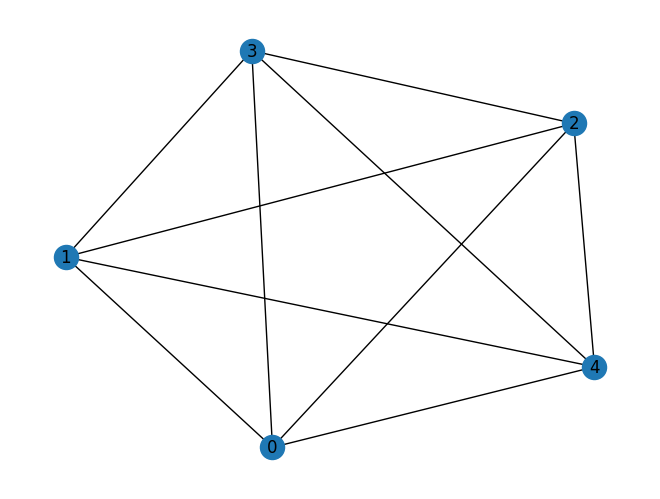

In [5]:
A = np.array([
    [0, 1, 1, 1, 1],
    [1, 0, 1, 1, 1],
    [1, 1, 0, 1, 1],
    [1, 1, 1, 0, 1],
    [1, 1, 1, 1, 0]
])

draw_graph(A)

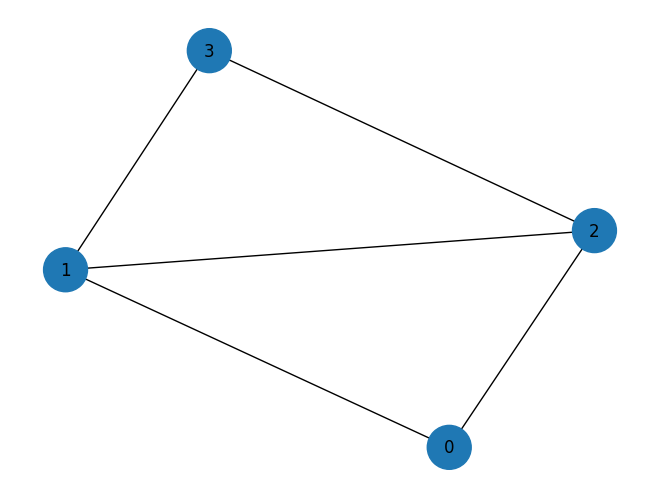

In [4]:
A = np.array([
    [0, 1, 1, 0],
    [1, 0, 1, 1],
    [1, 1, 0, 1],
    [0, 1, 1, 0]
])

draw_graph(A)

In [85]:
# Ví dụ ta tìm được x và y
y = np.array([1, 1, 1, 0])
x = np.array([
    [1, 0, 0, 1],
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 0]
])

# Điều kiện 1: Tổng cột bằng 1 -> mỗi node chỉ thuộc một domatic set
for i in range(x.shape[1]):
    assert sum(x[:,i]) == 1

# Điêu kiện 2: Điều kiện của số domatic 
for j in range(x.shape[0]):
    output = (x[j, :] + x[j, :] @ A)
    assert np.all(output >= y[j])

3
Kết quả ma trận X:
 [[-0.  1.  0.  0.]
 [ 1. -0. -0.  1.]
 [ 0. -0.  1.  0.]]
Kết quả vector y:
 [1. 1. 1.]


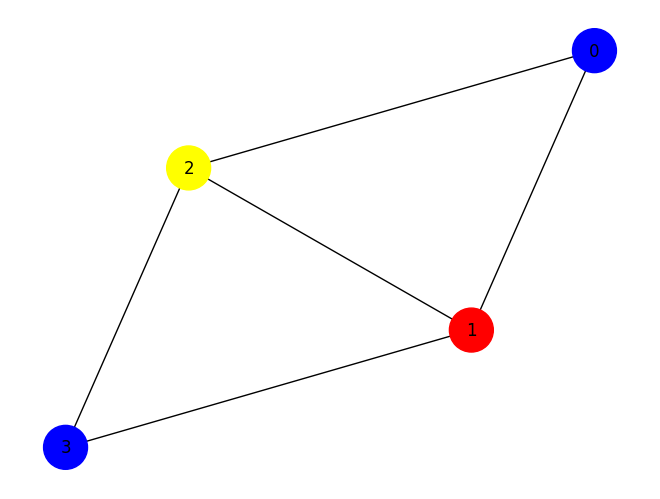

In [44]:
import cvxpy as cp
import numpy as np

def domatic_number(A):
    n = A.shape[0]
    degrees = np.sum(A, axis=1)
    m = np.min(degrees) + 1 # cận trên là bằng min degree + 1
    x = cp.Variable((n, m), integer=True)
    y = cp.Variable(m, integer=True)
    constraints = []

    # Điều kiện 1: Tổng cột bằng 1 -> mỗi node chỉ thuộc một domatic set
    for i in range(n):
        constraints.append(cp.sum(x[i, :]) == 1)

    # Điêu kiện 2: Điều kiện của số domatic 
    for j in range(m):
        for i in range(n):
            neighbor_sum = cp.sum([x[v, j] for v in range(n) if A[i, v] == 1])
            constraints.append(x[i, j] + neighbor_sum - y[j] >= 0)

    # Điều kiện 3: 0 <= x,y <= 1
    constraints.append(x >= 0)
    constraints.append(x <= 1)
    constraints.append(y >= 0)
    constraints.append(y <= 1)

    # Hàm mục tiếu
    objective = cp.Maximize(cp.sum(y))

    # Giải bài toán
    problem = cp.Problem(objective, constraints)
    problem.solve()

    return x.value.T, y.value


A = np.array([
    [0, 1, 1, 0],
    [1, 0, 1, 1],
    [1, 1, 0, 1],
    [0, 1, 1, 0]
])

x, y = domatic_number(A)
print("Kết quả ma trận X:\n", x)
print("Kết quả vector y:\n", y)

node_colors = assign_color(x, y)
draw_graph(A, node_colors=node_colors)

### **Ví dụ 2: Hypercube graph**

[[0 1 1 0 1 0 0 0]
 [1 0 0 1 0 1 0 0]
 [1 0 0 1 0 0 1 0]
 [0 1 1 0 0 0 0 1]
 [1 0 0 0 0 1 1 0]
 [0 1 0 0 1 0 0 1]
 [0 0 1 0 1 0 0 1]
 [0 0 0 1 0 1 1 0]]


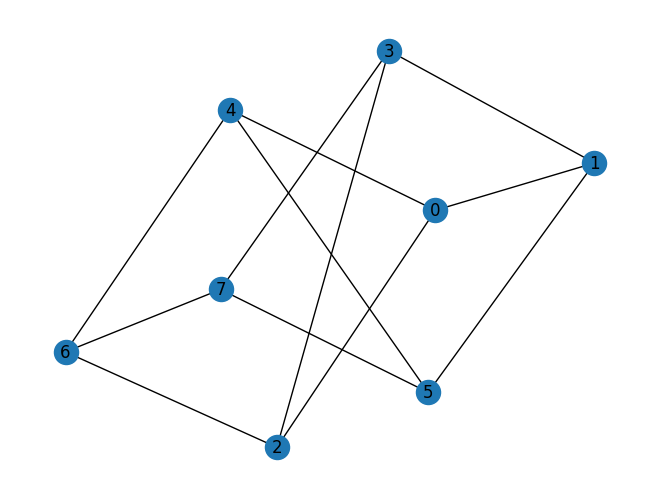

In [48]:
n = 2**3
V = range(n)
A = np.zeros((n,n), dtype=np.int64)

# Adjacency-matrixa
for i in range(n):
    for j in range(n):
        if ((i < j) & (bin(i^j).count('1') == 1)):
            A[i,j] = A[j,i] = 1

print(A)
draw_graph(A)

In [ ]:
x, y = domatic_number(A)
print("Kết quả ma trận X:\n", x)
print("Kết quả vector y:\n", y)

node_colors = assign_color(x, y)
draw_graph(A, node_colors=node_colors)

In [53]:
from gurobipy import Model, GRB
import gurobipy

def domatic_for_hypercube(A):
    res = []
    
    # cận trên là bằng min degree + 1
    degrees = np.sum(A, axis=1)
    m = np.min(degrees) + 1

    f = Model ("Domatic")
    x = f.addVars(V, range(m), vtype=GRB.BINARY, name='vtx-col') 
    y = f.addVars(range(m), vtype=GRB.BINARY, name='grp')

    # Điều kiện 1: Tổng cột bằng 1 -> mỗi node chỉ thuộc một domatic set 
    f.addConstrs((sum(x[u,i] for i in range(m)) == 1 for u in V), name='partition')

    # Điêu kiện 2: Điều kiện của số domatic
    f.addConstrs((x[u,i] + sum(x[v,i] for v in V if A[u,v] == 1) - y[i] >= 0 for u in V for i in range(k)), name='dominance')

    # Hàm mục tiêu
    f.setObjective(gurobipy.quicksum(y[i] for i in range(m)), GRB.MAXIMIZE)
    f.optimize()

    for u in V: 
        res.append(round(sum(x[u,i].X * (i+1) for i in range(m))))
    return res
    
    
res = domatic_for_hypercube(A)
res

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: 12th Gen Intel(R) Core(TM) i9-12900H, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 40 rows, 36 columns and 192 nonzeros
Model fingerprint: 0xcbcbf087
Variable types: 0 continuous, 36 integer (36 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1.0000000
Presolve time: 0.00s
Presolved: 40 rows, 36 columns, 192 nonzeros
Variable types: 0 continuous, 36 integer (36 binary)

Root relaxation: objective 4.000000e+00, 23 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       4.0000000    4

[4, 2, 1, 3, 3, 1, 2, 4]

In [55]:
def draw_graph(A, node_colors=None, node_sizes=[1000, 1000, 1000, 1000]):
    graph = nx.Graph()
    edge_list = convert_adj_to_edgelist(A)
    graph.add_edges_from(edge_list)
    if node_colors is not None:
        nx.draw(graph, with_labels=True, node_color=node_colors)
    else:
        nx.draw(graph, with_labels=True)
    plt.show()

In [ ]:
def assign_color(x, y):
    
    node_colors = ['c'] * x.shape[1]
    for j in range(y.shape[0]):
        if y[j] != 1:
            continue
        for i in range(x.shape[1]):
            if x[j,i] == 1:
                node_colors[i] = default_color[j]
    return node_colors

In [54]:
default_color = ['red', 'blue', 'yellow', 'green', 'orange', 
                'purple', 'pink', 'brown', 'magenta', 'cyan']

for i in range(len(res)):
    res[i] = default_color[res[i]]
    
res

['orange', 'yellow', 'blue', 'green', 'green', 'blue', 'yellow', 'orange']

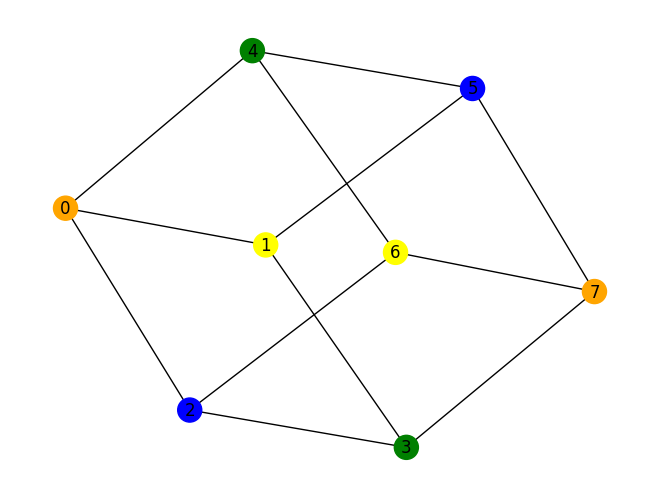

In [56]:
draw_graph(A, node_colors=res)